In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
from IPython.display import clear_output

## Dataset import

In [5]:
languages=[]
data=[]
X=[]
y=[]
with open('name2lang.txt','r') as f:
    for line in f:
        line=line.split(',')
        name=line[0].strip()
        lang=line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name,lang))
        
n_languages=len(languages)

In [6]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [7]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


## Train-test split

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [11]:
print(len(X_train),len(X_test))

16040 4010


## Encoding names and languages

In [15]:
all_letters=string.ascii_letters+" .,;'"
n_letters=len(all_letters)
print(n_letters)

57


In [16]:
def name_rep(name):
    rep=torch.zeros(len(name),1,n_letters)
    for index,letter in enumerate(name):
        pos=all_letters.find(letter)
        rep[index][0][pos]=1
    return rep

In [17]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)],dtype=torch.long)

In [18]:
name_rep("Abreu")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [20]:
lang_rep("Portuguese")

tensor([0])

## Data visualization

In [22]:
count={}
for l in languages:
    count[l]=0
for d in data:
    count[d[1]]+=1

In [23]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


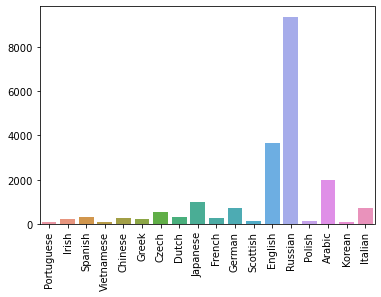

In [27]:
plt_=sns.barplot(list(count.keys()),list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(),rotation=90)
plt.show()

## Basic network and testing baseline inference

In [37]:
class RNN_net(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN_net,self).__init__()
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o=nn.Linear(input_size+hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
        
    def forward(self,input_,hidden):
        combined=torch.cat((input_,hidden),1)
        hidden=self.i2h(combined)
        output=self.i2o(combined)
        output=self.softmax(output)
        return output,hidden
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [38]:
n_hidden=128
net=RNN_net(n_letters,n_hidden,n_languages)

In [39]:
def infer(net,name):
    net.eval()
    name_ohe=name_rep(name)
    hidden=net.init_hidden()
    
    for i in range(name_ohe.size()[0]):
        output,hidden=net(name_ohe[i],hidden)
    
    return output

In [40]:
output=infer(net,'Adam')
index=torch.argmax(output)
print(output,index)

tensor([[-2.9541, -2.8511, -2.9433, -2.8201, -2.9019, -2.7728, -3.0686, -2.8366,
         -3.0110, -2.8145, -2.8839, -2.8356, -2.9077, -2.9345, -2.8338, -2.7974,
         -2.9350, -2.9787]], grad_fn=<LogSoftmaxBackward>) tensor(5)


## Evaluate model

In [41]:
def dataloader(npoints,X,y):
    to_ret=[]
    for i in range(npoints):
        index=np.random.randint(len(X))
        name,lang=X[index],y[index]
        to_ret.append((name,lang,name_rep(name),lang_rep(lang)))
    return to_ret

In [42]:
dataloader(2,X_train,y_train)

[('Piffer',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [43]:
def eval(net,n_points,k,X,y):
    data=dataloader(n_points,X,y)
    correct=0
    
    for name,lang,name_ohe,lang_rep in data:
        output=infer(net,name)
        val,indices=output.topk(k)
        
        if lang_rep in indices:
            correct+=1
    
    accuracy=correct/n_points
    return accuracy

In [44]:
eval(net,1000,3,X_test,y_test)

0.169

## Training

In [45]:
def train(net,opt,criterion,n_points):
    opt.zero_grad()
    total_loss=0
    data=dataloader(n_points,X_train,y_train)
    
    for name,language,name_ohe,lang_rep in data:
        hidden=net.init_hidden()
        
        for i in range(name_ohe.size()[0]):
            output,hidden=net(name_ohe[i],hidden)
            
        loss=criterion(output,lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss+=loss
    
    opt.step()
    
    return total_loss/n_points

In [47]:
criterion=nn.NLLLoss()
opt=optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

In [48]:
train(net,opt,criterion,200)

tensor(2.8803, grad_fn=<DivBackward0>)

In [49]:
eval(net,1000,1,X_test,y_test)

0.484

In [53]:
def train_setup(net,lr=0.01,n_batches=100,batch_size=10,momentum=0.9,display_freq=5):
    crietrion=nn.NLLLoss()
    opt=optim.SGD(net.parameters(),lr=lr,momentum=momentum)
    
    loss_arr=np.zeros(n_batches+1)
    
    for i in range(n_batches):
        loss_arr[i+1]=(loss_arr[i]*i+train(net,opt,crietrion,batch_size))/(i+1)
        
        if i%display_freq==display_freq-1:
            clear_output(wait=True)
            
            print("Iteration",i,"Top-1",eval(net,len(X_test),1,X_test,y_test),"Top-2:",eval(net,len(X_test),2,X_test,y_test))
            plt.figure()
            plt.plot(loss_arr[1:i],"-*")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()
            print("\n\n")
            

Iteration 199 Top-1 0.6827930174563591 Top-2: 0.8117206982543641


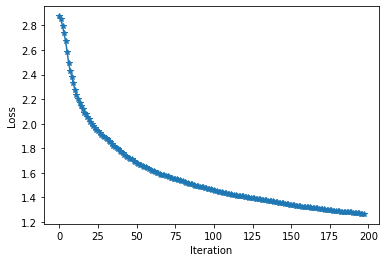

In [56]:
n_hidden=128
net=RNN_net(n_letters,n_hidden,n_languages)
train_setup(net,lr=0.0005,n_batches=200,batch_size=256)